# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [2]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [3]:
!pip install wntr
%matplotlib inline
import wntr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.2 MB 5.4 MB/s 


In [239]:
import utils
from utils.Network import WDN
from utils.Dataloader import Dataloader

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)

<module 'utils.Dataloader' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/utils/Dataloader.py'>

## Main

### Testing

In [5]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


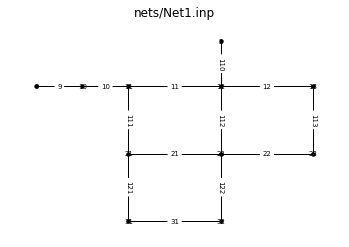

In [240]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()

In [283]:
def gen_single_data(wdn, leakage_node='', end_time=30*24, include_time=False):

  # Labels
  y = np.zeros((end_time+1,))

  # Construct leakages
  leakages = []
  if leakage_node:
    leakage_start = np.random.randint(end_time // 2, end_time * 9 // 10)
    leakage_strength = round(0.0009 + np.random.rand() / 2000, 4)
    leakages.append((leakage_node, leakage_strength, leakage_start+10*24, end_time+10*24))
    y[leakage_start:] = 1
  
  # Run simulation and remove first 10 convergence days
  p = wdn.simulate(end_time+10*24, leakages)[10*24:]

  # Add noise
  noise = np.random.normal(0, 0.15, [len(p), len(wdn.important_nodes)])
  p.loc[:, wdn.important_nodes] = p.loc[:, wdn.important_nodes] + noise

  # Features
  data = Dataloader(p, wdn.important_nodes)
  X = data.get_nodes(include_time=include_time)

  return X, y

Leakage at 400 Day 16 Hour 16


<Figure size 432x288 with 0 Axes>

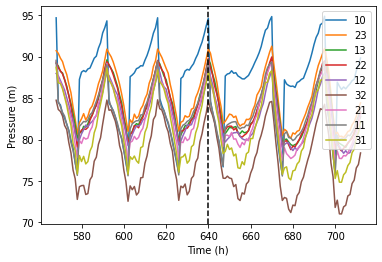

<Figure size 432x288 with 0 Axes>

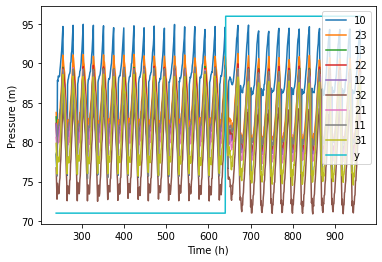

In [294]:
X, y = gen_single_data(wdn, '12')
leakage_at = round(30*24 - y.sum())
print('Leakage at', leakage_at, 'Day', leakage_at // 24, 'Hour', leakage_at % 24)

plot(X.loc[240+leakage_at-3*24:leakage_at+240+3*24,:], line_at=[240+leakage_at])

X['y'] = y * (96 - 71) + 71
plot(X)